# Machine Learning for Human Phenotype Classification

In [38]:
### Some imports
# All packages are included in the Anaconda python distribution and integral part of a machine learning Python environment).
import numpy as np               # efficient matrix-vector operations
import pandas as pd              # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns            # data visualization  
sns.set_style("whitegrid")        # set the figure default style
sns.set_context("talk")
sns.set(font_scale=1.5)          # bigger fonts in images

import matplotlib.pyplot as plt  # basic plotting

# some not so standard imports:
import importlib                 # enable reloading of libraries
import plotting_util as util     # useful plotting tools for teaching (see plotting_utils.py)
importlib.reload(util)
import logistic_regression
importlib.reload(logistic_regression)

import time                      # timing (for example to benchmark an algorithm)

## Diagnosing Breast cancer biopsies using Logistic Regression

Wisconsin Diagnostic Breast Cancer (WDBC, 1993) data from UCI Machine Learning repository.

- 569 samples from patients with known diagnosis
- 357 benign
- 212 malignant
- 30 features extracted from fine needle aspirate slides

![title](uci_breast_cancer/papers/breast_cancer_nuclei_12938_2011_Article_597_Fig3_HTML.jpg)

We are given a number of features that describe the nuclei that have been determined from image processing techniques [Street et al, 1992].
While the original data consists of 30 features and all presented methods work with 30 features, we restrict ourselves to 2 features, the *concavity* and the *texture* of the nuclei for illustrative purposes.



In [39]:
X, y = util.load_data(columns=["concavity_mean", "texture_mean"])
print (X.drop(['bias'], axis=1).shape)
# X.drop(['bias'], axis=1).head()

(398, 2)


Note that we have added a constant feature to the matrix $\mathbf{X}$ with the column name 'bias'.

### Binary Classificaiton

**Classification** refers to the task of predicting a **class label** $y$, *i.e.*, the diagnosis, from a **feature vector** $\bf{x}$.
For the case, where $y$ can take one of two values, we speak of binary classification.

In machine learning, we assume that we are given pairs of $(\mathbf{x}, y)$, the so-called **training data**, we would like to **train** a function $f(\mathbf{x})$ that predicts the value of $y$.

For the task at hand, this means that for the image features, we 
Then given a new image for which we don't know the diagnosis, we can predict the diagnosis based on what we have learned from from the training data.
We call the new image the **test data**.

The shape of the nulei has been determined and coded in a number of features.
Let's look at the data:

In [40]:
print (y.shape)
print (y.unique())
print ("Benign samples    'B': {:}".format((y=='B').sum()))
print ("Malignant samples 'M': {:}".format((y=='M').sum()))

(398,)
['B' 'M']
Benign samples    'B': 249
Malignant samples 'M': 149


# plot the data

(-0.01, 0.45)

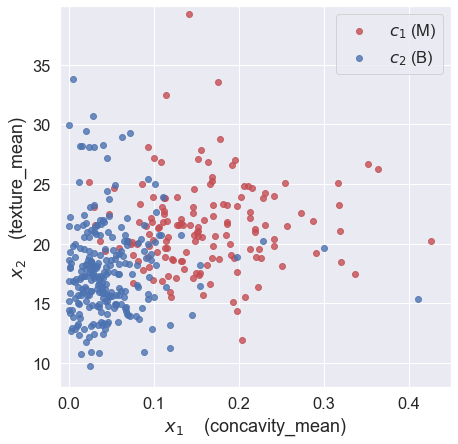

In [41]:
f, ax = plt.subplots(figsize=(7, 7))
ax = util.scatter_plot_kde2(X,y)
plt.ylim([8,39.9])
plt.xlim([-0.01,0.45])
# plt.savefig("./uci_breast_cancer/plots/scatter.png", dpi=600)

There are many ways to draw a function that separates the samples. But what is a good one?

In this lecture, we will look for a **linear** function for the features $x_1$ and $x_2$ that separates the two classes.
\begin{equation}
x_{1} \cdot w_1 + x_{2} \cdot w_2 + b =0
\end{equation}

Equivalently, we can use vector-notation:
\begin{equation}
\mathbf{x}\mathbf{w}=0,
\end{equation}

where 
\begin{equation}
\mathbf{x}=
\left[
\begin{matrix}
x_{1} & x_{2} & 1
\end{matrix}
\right],
\end{equation}
and
\begin{equation}
\mathbf{w}=
\left[
\begin{matrix}
w_{1} \\ w_{2} \\ b
\end{matrix}
\right].
\end{equation}
Note, that we have included the bias $b$ into the vector $\mathbf{w}$ by creating a new feature in $\mathbf{x}$ equal to 1.

/Users/christophlippert/Library/CloudStorage/OneDrive-Personal/HPI/Lectures/2024_SS_Math4ML/Math4ML-Code/week6/plotting_util.py:272: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, xx2, Z, cmap=cmap, alpha=0.05)


(-0.01, 0.45)

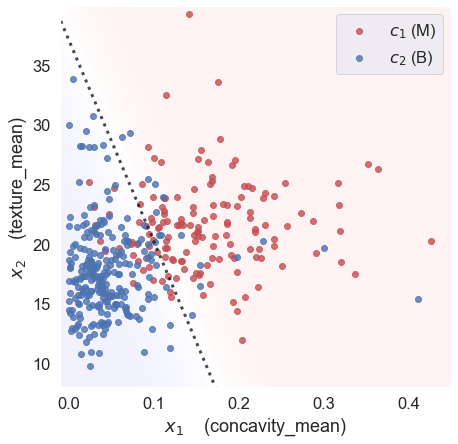

In [42]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(7,7))
ax, clf = util.plotfun2D_logreg(X,y, threshold=0.5, prob=True)
plt.ylim([8,39.9])
plt.xlim([-0.01,0.45])
# plt.savefig("./uci_breast_cancer/plots/scatter_decision_boundary.png", dpi=600)

/Users/christophlippert/Library/CloudStorage/OneDrive-Personal/HPI/Lectures/2024_SS_Math4ML/Math4ML-Code/week6/plotting_util.py:272: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, xx2, Z, cmap=cmap, alpha=0.05)


(-0.01, 0.45)

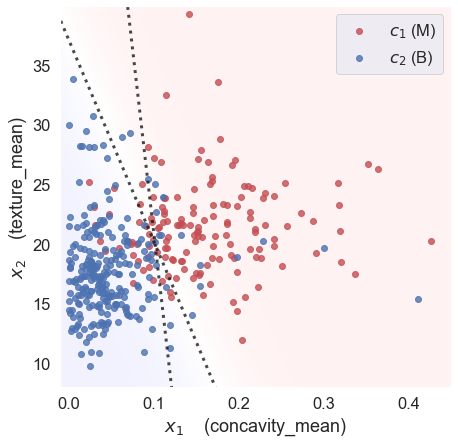

In [43]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(7,7))
ax, clf = util.plotfun2D_logreg(X,y, threshold=0.5, prob=True, second_line=True)
plt.ylim([8,39.9])
plt.xlim([-0.01,0.45])
# plt.savefig("./uci_breast_cancer/plots/scatter_decision_boundary_secondline.png", dpi=600)

The classifier predicts all samples on one side of the **decision boundary** to belong to one class, all others to the other class. 

As we observe, with a linear function, we have to accept that there are missclassifications, especially if we have a large training data set, the training data is rarely **linearly separable**.

## The logistic sigmoid

As the data are not separable, it is desirable to encode our degree of (un)-certainty by assigning a **probability** for a sample belonging to class $c_1$ each sample.

In this example, $c_1$ refers to a Malignant diagosis.

\begin{equation}
p(y=c_1|\mathbf{x}) = \pi(\mathbf{xw})
\end{equation}

$y$ is the class label of the sample and $\pi$ is the **logistic sigmoid**.

The **logistic** $\pi(a)$ is a function between 0 and 1, making it suited for modeling probabilities. It is called a **sigmoid** function because of its *s*-shape.

\begin{equation}
\pi(a) := \frac{1}{1+\exp{\left(-a\right)}} = \frac{\exp{\left(a\right)}}{1+\exp{\left(a\right)}}
\end{equation}

Here, as we are modeling linear functions, $a=\mathbf{x}_n\mathbf{w}$, where $\mathbf{x}_n$ is the **feature vector** for the $n$-th individual (given), and $\mathbf{w}$ is a **weight vector** that we would like to find.

In [44]:
def logistic(a):
    """
    returns the logistic sigmoid \pi(a)
    Keyword arguments:
    a -- scalar or numpy array
    """
    expa = np.exp(a)
    return expa / (1.0 + expa)

/var/folders/bw/7wvb07ss3h57p5s47w2rr3080000gn/T/ipykernel_39553/1493706288.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, xx2, logistic(xx1), cmap='bwr', alpha=0.05)


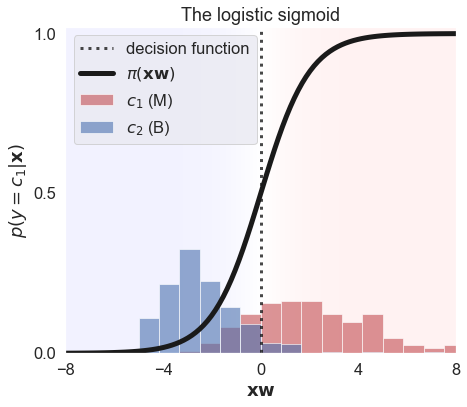

In [45]:
a = np.linspace(-8.0,8.0,100) # create 100 points on a line
# Set up the figure
f, ax = plt.subplots(figsize=(7, 6))
linex=np.arange(-9, 9, 0.003)
liney = np.arange(-0.1, 1.1, 0.01)
plt.plot([0,0],[-1,2],':k',alpha=0.8,linewidth=3)
plt.plot(a, logistic(a), 'k', linewidth=5)
# plt.plot(a, 1.0-logistic(a), 'k:', linewidth=5, alpha=0.5)

plt.xlim([-8,8])
plt.ylim([-0.0,1.02])
plt.yticks([0.0,0.5,1.0])
plt.xticks([-8,-4,0,4,8])

# ax.patch.set_facecolor('white')
plt.legend(['decision function','$\pi(\mathbf{xw})$','B',"R"])

xx1, xx2 = np.meshgrid(linex, liney)
plt.pcolormesh(xx1, xx2, logistic(xx1), cmap='bwr', alpha=0.05)

ax.patch.set_facecolor('white')


ax = plt.xlabel('$\mathbf{xw}$')
ax = plt.ylabel('$p(y=c_1|\mathbf{x})$')

clf = util.LogisticRegression()
clf.fit(X=X.values,y=y.values[:,np.newaxis])
Xw = X.values.dot(clf.w)
bins = np.linspace(-10, 10, 25)
plt.hist(Xw[y.values=='M'], bins, alpha=0.6, label='M', color='r', density=True)
plt.hist(Xw[y.values=='B'], bins, alpha=0.6, label='B', color='b', density=True)
plt.legend(['decision function','$\pi(\mathbf{xw})$','$c_1$ (M)',"$c_2$ (B)"])


# plt.scatter(Xw, (y.values[:,np.newaxis]=="M") , (y.values[:,np.newaxis]=="M"), size=20)

ax = plt.title("The logistic sigmoid")
# plt.savefig("./uci_breast_cancer/plots/logistic_sigmoid_data.png", dpi=600)

AttributeError: 'Rectangle' object has no property 'normed'

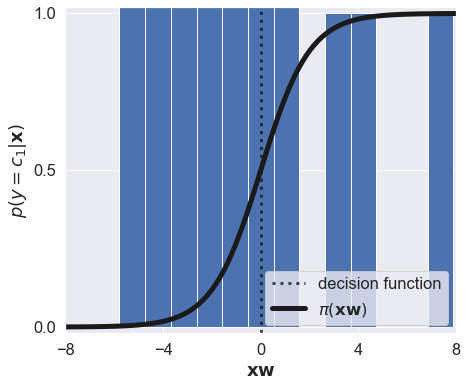

In [46]:
a = np.linspace(-8.0,8.0,100) # create 100 points on a line
# Set up the figure
f, ax = plt.subplots(figsize=(7, 6))
linex=np.arange(-9, 9, 0.003)
liney = np.arange(-0.1, 1.1, 0.01)
# xx1, xx2 = np.meshgrid(linex, liney)
# plt.pcolormesh(xx1, xx2, logistic(xx1), cmap='bwr', alpha=0.1)

plt.plot([0,0],[-1,2],':k',alpha=0.8,linewidth=3)
plt.plot(a, logistic(a), 'k', linewidth=5)
# plt.plot(a, 1.0-logistic(a), 'k:', linewidth=5, alpha=0.5)

plt.xlim([-8,8])
plt.ylim([-0.02,1.02])
plt.yticks([0.0,0.5,1.0])
plt.xticks([-8,-4,0,4,8])

# ax.patch.set_facecolor('white')
plt.legend(['decision function','$\pi(\mathbf{xw})$','B',"R"])




ax = plt.xlabel('$\mathbf{xw}$')
ax = plt.ylabel('$p(y=c_1|\mathbf{x})$')

clf = util.LogisticRegression()
clf.fit(X=X.values,y=y.values[:,np.newaxis])
Xw = X.values.dot(clf.w)
bins = np.linspace(-10, 10, 20)
plt.hist(Xw[y.values=='B'], bins, alpha=0.5, label='B', color='b', density=True)
plt.hist(Xw[y.values=='M'], bins, alpha=0.5, label='M', color='r', density=True)
# plt.scatter(Xw, (y.values[:,np.newaxis]=="M") , (y.values[:,np.newaxis]=="M"), size=20)

ax = plt.title("The logistic sigmoid")
plt.savefig("./uci_breast_cancer/plots/logistic_sigmoid_data.png", dpi=600)

Conversely, the probabily to belong to the class $c_2$ (Benign) is given by $1-\pi(a)$.
\begin{equation}
p(y_n=c_2|\mathbf{x}_n; \mathbf{w})= 1-\pi(\mathbf{x}_n\mathbf{w}) = \frac{1}{1+\exp{(\mathbf{x}_n\mathbf{w}})} 
\end{equation}

## Objective

We need to find a way to obtain a suitable set of weights.

We do so by writing down a function, the so-called **objective** function $L$ and then determine the weights $\mathbf{w}^{opt}$ that minimize $L$.

We would like to assign high probability to all the instances that belong to the target class and low probability otherwise.

## Loss Function

The **loss function** measures the **errors** we make on the **training data**.
So for each error, we record a loss.
As we are trying to assign high probabilities to the correct class, we would like to obtain a function that records a loss, whenever we assign low probability to the correct class $c_{true}$.

/var/folders/bw/7wvb07ss3h57p5s47w2rr3080000gn/T/ipykernel_39553/3939639547.py:2: RuntimeWarning: divide by zero encountered in log
  yy = -np.log(xx)


(0.0, 10.0)

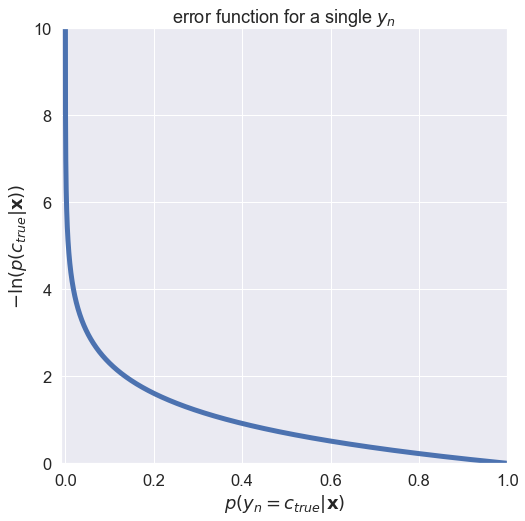

In [27]:
xx = np.arange(0,1.0,0.00001)
yy = -np.log(xx)
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(xx,yy, linewidth=5)
plt.title("error function for a single $y_n$")
plt.ylabel("$-\ln( p(c_{true}|\mathbf{x}) )$")
plt.xlabel("$p(y_n=c_{true}|\mathbf{x})$")
plt.xlim([-0.01,1.0])
plt.ylim([0,10])
# plt.savefig("./uci_breast_cancer/plots/log_error.png", dpi=600)

By summing this loss over all samples, we obtain the **log-loss** or **cross-entropy** function.

\begin{equation}
loss = -\sum_{n\in c_1} \ln( \pi(\mathbf{x}_n\mathbf{w}) ) - \sum_{n'\in c_2} \ln( 1-\pi(\mathbf{x}_{n'}\mathbf{w}) )
\end{equation}

## Regularizer

In addition to the loss, we define the regularizer as a fcuntion that penalizes very large values of $\mathbf{w}$ and to improve numerical stability.
In this example, we use the square of the Euclidean norm of $\mathbf{w}$ as regularizer.

\begin{equation}
regularizer = 0.5 \cdot \lambda \cdot \sum_{d=1}^{D}{w_d}^2
\end{equation}

The (hyper)-parameter $\lambda$ weighs the importance of the regularizer vs. the loss. In this example, we always use $\lambda=10^{-3}$.

In-depth discussion of the regularizer is beyond the scope of this lecture.

Text(0.5, 1.0, 'Weight Shrinkage')

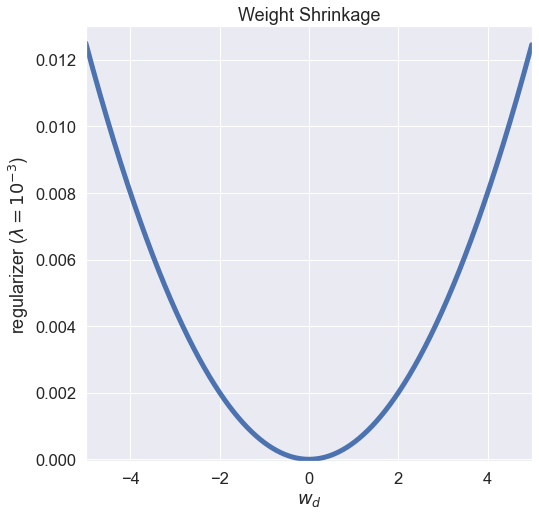

In [28]:
xx = np.arange(-5,5,0.01)
yy = 0.001*0.5 * xx * xx
f, ax = plt.subplots(figsize=(8, 8))
plt.plot(xx,yy,linewidth=5)
plt.xlim([-5,5])
plt.ylim([-0.00006,0.013])
plt.xlabel("$w_d$")
plt.ylabel("regularizer ($\lambda=10^{-3}$)")
plt.title("Weight Shrinkage")
# plt.savefig("./uci_breast_cancer/plots/regularizer.png",dpi=600)

## Combined objective
Taken together, we obtain the **Logistic Regression objective** $L(\mathbf{w})$.
\begin{equation}
L(\mathbf{w}) = \underbrace{-\sum_{n\in c_1} \ln( \pi(\mathbf{x}_n\mathbf{w}) ) - \sum_{n'\in c_2} \ln( 1-\pi(\mathbf{x}_{n'}\mathbf{w}) )}_{loss} + \underbrace{ \lambda \cdot 0.5 \cdot \sum_{d=1}^{D}{w_d}^2}_{regularizer}
\end{equation}

## Fitting the model
Now that we have an objective, how do we obtain a good set of parameters?

Let's look at the objective in 2 dimensions.

[iteration 7, 0.0015s]: objective: 1.250e+02, gradient l2 norm : 2.266e-08


/Users/christophlippert/Library/CloudStorage/OneDrive-Personal/HPI/Lectures/2024_SS_Math4ML/Math4ML-Code/week6/plotting_util.py:112: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, xx2, Z, cmap="viridis")


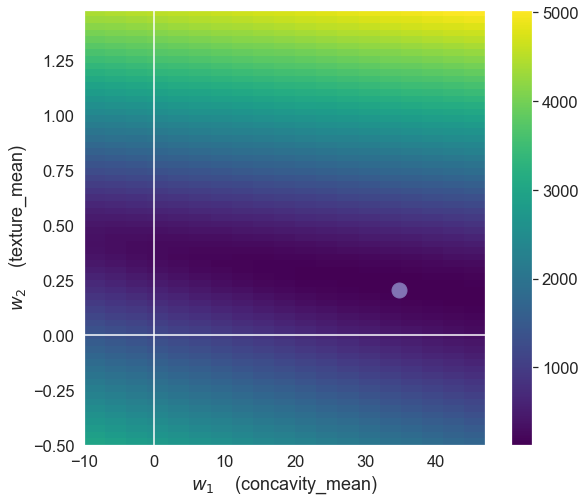

In [29]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(9, 8))
ax = util.eval_optimizer(X,y)
# plt.savefig("./uci_breast_cancer/plots/objective_heatmap_2d.png", dpi=600)

The image visualizes the objective $L$ as a function of the two weights $w_1$ and $w_2$, with objective values going from low (yellow) to high (red). The **minimum** is marked by a blue dot.

### Taking the derivative

The derivative of the objective with respect to a single $w_d$ is defined as follows:

\begin{equation}
\frac{\partial L}{\partial w_d} = \sum_n^{N}{x_{nd}} \cdot
 \left( \pi\left(\mathbf{x}_n\mathbf{w}_n\right)-I\left(\mathbf{y}_n== c_1\right)\right) + \lambda \cdot w_d
\end{equation}

$I(a==b)$ denotes the indicator function, which yields 1 if $a=b$ and 0 otherwise.

The sign of the derivative indicates the direction in which the objective gets larger or smaller and the magnitude the rate.

### The gradient

By stacking all partial derivatives into a single vector, we obtain the gradient $\nabla_\mathbf{w} (L)$.

\begin{equation}
\nabla{L}\left(\mathbf{w}^{t}\right) =
\left[\begin{matrix}
\frac{\partial L}{\partial w^t_1}\\
\vdots\\
\frac{\partial L}{\partial w^t_D}
\end{matrix}\right]
=
\underbrace{\mathbf{X}^{T}
 \left( \pi\left(\mathbf{X}\mathbf{w}^t\right)-I\left(\mathbf{y}==c_1\right)\right)}_{\nabla{\text{loss}}\left(\mathbf{w}^{t}\right)}+ \underbrace{\lambda \cdot \mathbf{w}^t}_{\nabla{\text{regularizer}}\left(\mathbf{w}^{t}\right)}
\end{equation}

$\nabla_\mathbf{w} (L)$ is a $D$-dimensional vector pointing in the direction of steepest growth of the objective and in the opposite direction in which the steepest reduction.
Using the gradient, we can define a simple optimization algorithm.

#### Steepest descent

The steepest descent algorithm uses the gradient by making small steps in the direction $-\nabla_{\mathbf{w}^{t}} (L)$. You can think about it as being on a hill and descending the hill in the steepest direction downwards.
Therefore the algorithm is called **steepest descent**.

given learning rate $0<\alpha<1.0$ and current weight estimate $\mathbf{w}^{t}$.
Iterate by setting $\mathbf{w}^{t+1} = \mathbf{w}^{t} - \alpha \cdot \nabla_{\mathbf{w}^{t}} (L)$.

A typical value for $\alpha$ is around $10^{-4}$.

A problem with steepest descent is that the estimate tends to oscillate and often even overshoots and diverges (leading to an increase in the objetive). Getting the learning rate right is very hard, trading off progress in learning and risk of diverging. Many tricks exit to improve learning in gradient descent, such as weight decay, where the learning rate is gradually reduced during learning.

[iteration 7, 0.0020s]: objective: 1.250e+02, gradient l2 norm : 2.266e-08
[iteration 200000, 16.8855s]: objective: 1.250e+02, gradient l2 norm : 2.804e-02


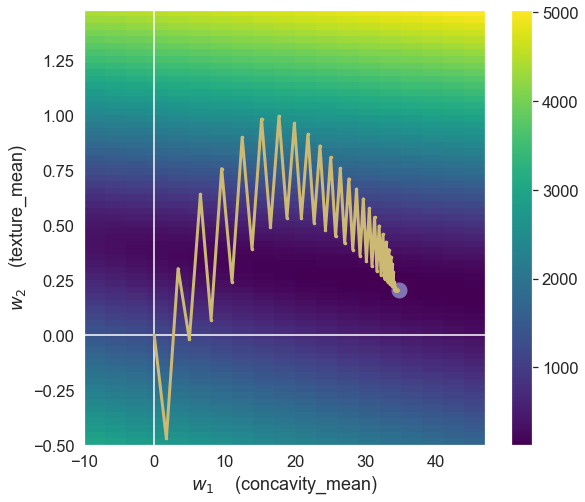

In [30]:
f, ax = plt.subplots(figsize=(9, 8))
ax = util.eval_optimizer(X,y, steep=True)
# plt.savefig("./uci_breast_cancer/plots/objective_heatmap_2d_steepest.png", dpi=600)

In the image above, where we applied weight decay, multiplying the learning rate by $1-10^{-6}$ after each iteration, the learning does not converge to the minimum (the blue dot) after 200.000 iterations.

#### Using curvature information

We can build a better learning algorithm by using second order information, utilizing a second-order Taylor-series expansion around the current weight estimate $\mathbf{w}^t$.

[iteration 7, 0.0012s]: objective: 1.250e+02, gradient l2 norm : 2.266e-08


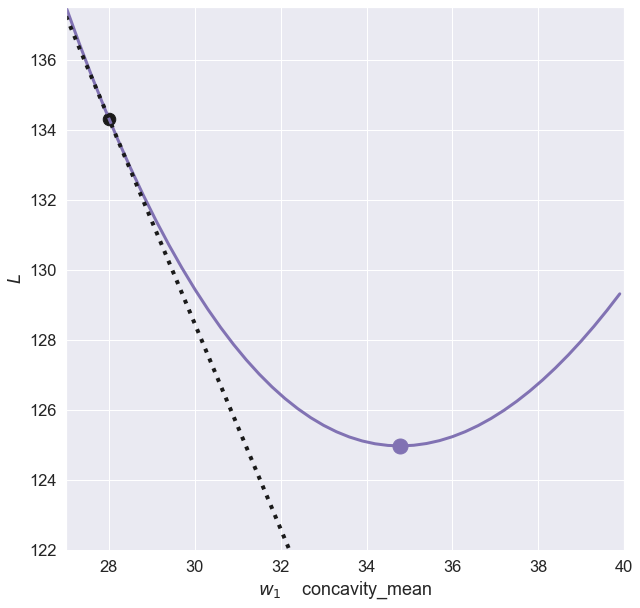

In [31]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(10, 10))
ax = util.eval_optimizer1D(X, y, taylor1=True, taylor2=False)
# plt.savefig("./uci_breast_cancer/plots/derivative_1D.png", dpi=600)

[iteration 7, 0.0020s]: objective: 1.141e+02, gradient l2 norm : 1.091e-07


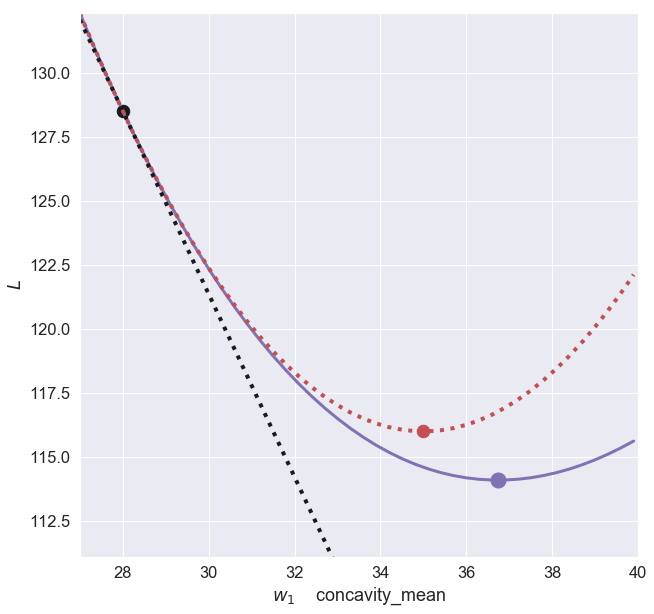

In [15]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(10, 10))
ax = util.eval_optimizer1D(X, y, taylor1=True, taylor2=True)
plt.savefig("./uci_breast_cancer/plots/newton_step_1D.png", dpi=600)

The image depicts the idea for a single weight $w_1$. At the current estimate $w_1^{t}$, we compute the first and second derivatives of the objective to form a parabolic fit to the objective $L$. Then, we obtain $w_1^{t+1}$ as the minimum of that parabolic and iterate.

### The Hessian
In higher dimensions, the matrix second derivatives is called the Hessian $\nabla^2_{\mathbf{w}}(L)$.

\begin{equation}
\mathbf{H}_{\mathbf{w}^{t}}  =
\left[\begin{matrix}
{\partial^{2} L }/{\partial^2 w_1} & {\partial^{2} L }/{\partial w_1 \partial w_2} & \dots & {\partial^{2} L }/{\partial w_1 \partial w_D}\\
\vdots & &\ddots  &\vdots\\
{\partial^{2} L }/{\partial w_D \partial w_1} & {\partial^{2} L }/{\partial w_D \partial w_2} & \dots & {\partial^{2} L }/{\partial^2 w_D}
\end{matrix}\right] 
\end{equation}

\begin{equation}
\mathbf{H}_{\mathbf{w}^{t}}= 
\underbrace{
\left(\mathbf{X}  
\mathrm{diag}\left(
\pi\left(\mathbf{X}\mathbf{w}^{t}\right) \cdot 
\left(\mathbf{1}-\pi(\mathbf{X}\mathbf{w}^{t}\right)
\right)
\right)^{T} \mathbf{X} 
}_{\mathbf{H}_{\mathbf{w}^{t}} (\mathrm{loss})}+\underbrace{ \lambda \cdot \mathbf{I}_{D\times D}}_{\mathbf{H}_{\mathbf{w}^{t}} (\mathrm{regularizer})}
\end{equation}

### The Newton-Raphson algorithm

The update rule using second order information can be derived by iterating the following update until the Euclidiean ($l^2$) norm of the gradient is close to 0.
\begin{equation}
\mathbf{w}^{t+1} = \mathbf{w}^{t} - \mathbf{H}_{\mathbf{w}^t}^{-1} \nabla{L}\left(\mathbf{w}^{t}\right)
\end{equation}

[iteration 7, 0.0021s]: objective: 1.250e+02, gradient l2 norm : 2.266e-08


/Users/christophlippert/Library/CloudStorage/OneDrive-Personal/HPI/Lectures/2024_SS_Math4ML/Math4ML-Code/week6/plotting_util.py:112: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, xx2, Z, cmap="viridis")


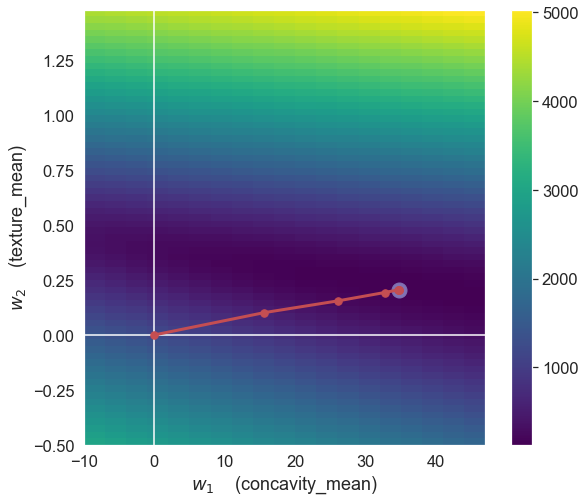

In [33]:
f, ax = plt.subplots(figsize=(9,8))
ax = util.eval_optimizer(X,y, steep=True, irls=True)
# plt.savefig("./uci_breast_cancer/plots/objective_heatmap_2d_steepest_irls.png", dpi=600)

The blue line corresponds to minimization using the Newton-Raphson algorithm.
We observe that the curvature information provided by $\mathbf{H}_{\mathbf{w}^{t}}$ dramatically speeds up optimization, with convergence achieved after 7 iterations.

### The implementation of logistic regression
Let's put things together and implement logistic regression.

In [34]:
class LogisticRegression(object):
    """
    Implements logistic regression classifier with the objective
    \sum_{n\in class_{1}} \log(\pi(x_n.dot(w))) + \sum_{n\in class_{0}} \log(1-\pi(x_n.dot(w))) + lambd/2 * w.T.dot(w)
    """

    def __init__(self, lambd=1e-3, tol=1e-5, max_iter=100):
        """
        Keyword arguments:
        lambd     -- regularization paramter for L2 norm of w (scalar or numpy 1D array with length equal to the number of dimensions) (default: 1e-5)
        tol       -- tolerance of the optimizer (default: 1e-5)
        max_iter  -- maximum number of interations of the optimizer (default: 100)
        """
        self.w = None # create a placeholer for the weights w
        self.class_labels = None # crete a placeholder for the list of class labels
        self.lambd = lambd
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, X, y):
        """
        minimize the objective
        \sum_{n\in class_{1}} \log(\pi(x_n.dot(w))) + \sum_{n\in class_{0}} \log(1-\pi(x_n.dot(w))) + lambd/2 * w.T.dot(w)
        """
            
        self.class_labels = np.unique(y)
        if len(self.class_labels)>2:
            raise Exception("too many classes")
        self.w = np.zeros((X.shape[1], 1)) # zero-init w
        num_iter = 0
        gradient_last = np.inf # initialize the gradient to a large number
        # Newton-Raphson / IRLS updates
        while (np.sqrt(gradient_last*gradient_last).sum() > self.tol) and (num_iter<self.max_iter):
            gradient_last = self.perform_update(X=X,y=y)
            num_iter += 1
        return self
    
    def perform_update(self, X, y):
        """
        compute and perform a single step in the iterative optimization scheme
        """
        # compute the Iteratively Reweighted Least Squares update (equiv. Newton-Raphson)
        hessian = self.hessian(X=X, y=y)
        gradient = self.gradient(X=X, y=y)
        update = - np.linalg.lstsq(hessian, gradient, rcond=None)[0]
        self.w = self.w + update
        return gradient
    
    def predict_proba(self, X, min_val=1e-15):
        """
        compute the probabilities of the lexicographically larger class label
        """
        z = logistic(np.dot(X, self.w))
        z[z<min_val] = min_val
        z[z>1-min_val] = 1-min_val
        return z
    
    def predict(self, X, threshold=0.5):
        """
        predict a class label using \pi(x)>=threshold
        """
        prediction =  np.array([self.class_labels[0]] * X.shape[0])[:,np.newaxis]
        prediction[self.predict_proba(X) >= threshold] = self.class_labels[1] 
        return prediction
    
    def objective(self, y, X):
        """
        L = \sum_{n\in class_{1}} \log(\pi(x_n.dot(w))) + \sum_{n\in class_{0}} \log(1-\pi(x_n.dot(w))) + lambd/2 * w.T.dot(w)
        """
        pi = self.predict_proba(X)
        log_0_pi = np.log(pi[y==self.class_labels[1]])
        log_1_pi = np.log(1.0-pi[y==self.class_labels[0]])
        loss = -log_0_pi.sum() - log_1_pi.sum() # this version is more stable for perfect prediction
        regularizer =  0.5*  (self.lambd * self.w * self.w).sum()
        return loss  + regularizer
    
    def gradient(self, X, y):
        """
        compute the [D x 1] gradient vector
        \nabla w := [dL / dw_j for each j \in 1..D]
        """
        pi = self.predict_proba(X)
        return np.dot(X.T, pi-(y==self.class_labels[1]))+ self.lambd * self.w
    
    def hessian(self, X, y):
        """
        compute the [D x D] Hessian matrix
        \nabla^2 w := [d^2 L / (dw_i dw_j) for each i,j \in 1..D]
        """
        pi = self.predict_proba(X)
        return  (X * (pi * (1.0-pi))).T.dot(X) + self.lambd * np.eye(X.shape[1])

### Evaluating the model

\begin{equation}
\text{accuracy} = \frac{1}{N} \text{# correctly classified}
\end{equation}

#### Confusion matrix

|          | Predicted Positive | Predicted Negative |
|----------| ------------------ |:------------------:|
| **Positive** | True Positive ($TP$) | False Negative ($FN$)|
| **Negative** | False Positive ($FP$)| True Negative ($TN$) |


#### Trade-off between Sensitivity and Specificity

\begin{equation}
\text{sensitivity} = \frac{TP}{TP + FN}
\end{equation}

\begin{equation}
\text{specificity} = \frac{TP}{TP + FP}
\end{equation}

### Train error vs. Test error

Let us compute these quantities on the test data:



number samples: 398
number M: 149
number B: 249
Accuracy   : 0.882
Sensitivity: 0.799
Specificity: 0.875


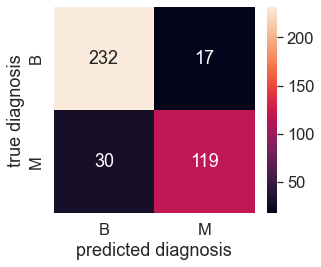

In [35]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(4.5,3.8))
util.plot_confusion_matrix(x=X, y=y, x_test=X, y_test=y,threshold=0.5)
# plt.savefig("confusion_matrix_train.png",dpi=600)

number samples: 171
number M: 63
number B: 108
Accuracy   : 0.895
Sensitivity: 0.825
Specificity: 0.881


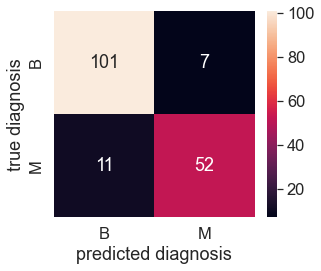

In [36]:
importlib.reload(util)
X_test,y_test = util.load_data(testing_data=True, columns=["concavity_mean", "texture_mean"])

f, ax = plt.subplots(figsize=(4.5,3.8))
util.plot_confusion_matrix(x=X, y=y, x_test=X_test, y_test=y_test,threshold=0.5)
# plt.savefig("confusion_matrix_test.png",dpi=600)

/Users/christophlippert/Library/CloudStorage/OneDrive-Personal/HPI/Lectures/2024_SS_Math4ML/Math4ML-Code/week6/plotting_util.py:272: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, xx2, Z, cmap=cmap, alpha=0.05)


(-0.01, 0.45)

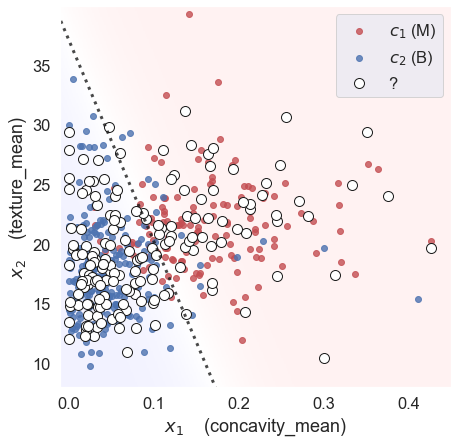

In [37]:
importlib.reload(util)
f, ax = plt.subplots(figsize=(7,7))
ax, clf = util.plotfun2D_logreg(X,y,X_test=X_test, y_test=y_test, threshold=0.5, prob=True)
plt.ylim([8,39.9])
plt.xlim([-0.01,0.45])
# plt.savefig("./uci_breast_cancer/plots/scatter_decision_boundary_test.png", dpi=600)

## Conclusions
- use data to derive a program instead of relying on expert
- need a target objective to learn and regularization to avoid overfitting
- predictions are uncertain -> probabilities
- fitting to data

## References
[Street et al, 1992] N. Street, W. Wolberg, O.L. Mangasarian:  Nuclear Feature Extraction For Breast Tumor Diagnosis. IS&T/SPIE 1993.